<a href="https://colab.research.google.com/github/123shwetarohokale/563-ShwetaR/blob/main/Furuta_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install mujoco
!pip show mujoco
!python -m mujoco.viewer

Name: mujoco
Version: 3.3.0
Summary: MuJoCo Physics Simulator
Home-page: https://github.com/google-deepmind/mujoco
Author: 
Author-email: Google DeepMind <mujoco@deepmind.com>
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, etils, glfw, numpy, pyopengl
Required-by: 
/usr/local/lib/python3.11/dist-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
ERROR: could not initialize GLFW

Press Enter to exit ...


In [8]:
xml_content = """<mujoco model="furuta_pendulum">
    <compiler angle="radian"/>
    <default>
        <joint armature="0.01" damping="0.1"/>
    </default>

    <worldbody>
        <body name="base">
            <joint name="base_joint" type="hinge" axis="0 0 1"/>
            <geom type="cylinder" size="0.05 0.1" rgba="0.3 0.3 0.3 1"/>

            <body name="arm" pos="0 0 0.1">
                <joint name="arm_joint" type="hinge" axis="0 1 0"/>
                <geom type="capsule" size="0.02 0.2" fromto="0 0 0 0.2 0 0" rgba="0.8 0.1 0.1 1"/>

                <body name="pendulum" pos="0.2 0 0">
                    <joint name="pendulum_joint" type="hinge" axis="1 0 0"/>
                    <geom type="capsule" size="0.02 0.15" fromto="0 0 0 0 -0.15 0" rgba="0.1 0.1 0.8 1"/>
                </body>
            </body>
        </body>
    </worldbody>

    <actuator>
        <motor joint="base_joint" ctrlrange="-1 1"/>
        <motor joint="arm_joint" ctrlrange="-1 1"/>
        <motor joint="pendulum_joint" ctrlrange="-1 1"/>
    </actuator>
</mujoco>"""

# Save the XML file
with open("furuta_pendulum.xml", "w") as file:
    file.write(xml_content)

print("Furuta Pendulum XML saved successfully!")


Furuta Pendulum XML saved successfully!


In [11]:
import mujoco as mj
import numpy as np

# Load MuJoCo model
model = mj.MjModel.from_xml_path("furuta_pendulum.xml")
data = mj.MjData(model)

# Define a function to extract transformation matrices
def get_transformation_matrix(model, data, body_name):
    """ Returns the 3x3 rotation matrix of a given body. """
    body_id = model.body(body_name).id  # Get the integer ID of the body
    return data.xmat[body_id].reshape(3, 3)

# Define a function to verify kinematic equations
def verify_kinematics(model, data):
    # Step simulation to update states
    mj.mj_step(model, data)

    # Extract joint angles
    theta_base = data.qpos[0]  # Base rotation
    theta_arm = data.qpos[1]   # Arm rotation
    theta_pendulum = data.qpos[2]  # Pendulum swing

    # Compute transformation matrices
    T_base = get_transformation_matrix(model, data, "base")
    T_arm = get_transformation_matrix(model, data, "arm")
    T_pendulum = get_transformation_matrix(model, data, "pendulum")

    # Print values for comparison
    print("Base Joint Angle (theta1):", theta_base)
    print("Arm Joint Angle (theta2):", theta_arm)
    print("Pendulum Joint Angle (theta3):", theta_pendulum)

    print("\nTransformation Matrices:")
    print("T_base:\n", T_base)
    print("T_arm:\n", T_arm)
    print("T_pendulum:\n", T_pendulum)

# Run the verification function
verify_kinematics(model, data)

Base Joint Angle (theta1): 0.0
Arm Joint Angle (theta2): 0.00012012818819378557
Pendulum Joint Angle (theta3): 2.101832490276905e-05

Transformation Matrices:
T_base:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
T_arm:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
T_pendulum:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


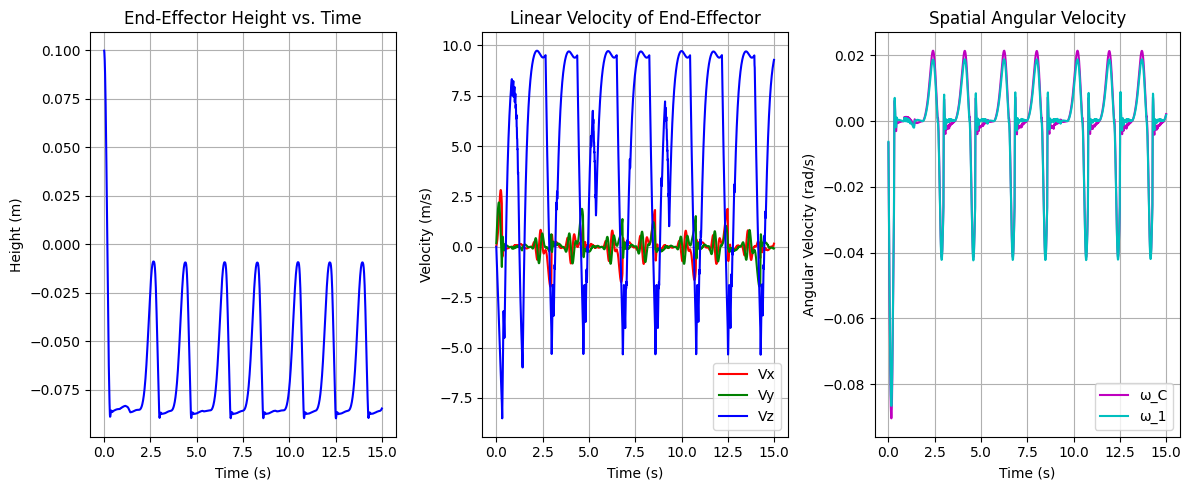

In [12]:
import mujoco as mj
import numpy as np
import matplotlib.pyplot as plt

# Load MuJoCo model
model = mj.MjModel.from_xml_path("furuta_pendulum.xml")
data = mj.MjData(model)

# Simulation parameters
dt = 0.01  # Time step
T = 15  # Total simulation time
num_steps = int(T / dt)  # Number of simulation steps

# Storage for results
time_vals = np.zeros(num_steps)
height_vals = np.zeros(num_steps)
linear_vel_vals = np.zeros((num_steps, 3))
angular_vel_vals_C = np.zeros((num_steps, 3))
angular_vel_vals_1 = np.zeros((num_steps, 3))

# Fourth-order Runge-Kutta integration function
def rk4_step(f, y, t, dt):
    k1 = f(t, y)
    k2 = f(t + dt / 2, y + dt * k1 / 2)
    k3 = f(t + dt / 2, y + dt * k2 / 2)
    k4 = f(t + dt, y + dt * k3)
    return y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# Define function for system dynamics
def dynamics(t, y):
    mj.mj_step(model, data)  # Step MuJoCo physics
    return np.array(data.qvel)  # Return velocity as derivative of position

# Simulation loop
for i in range(num_steps):
    time_vals[i] = i * dt

    # Apply control torque: τ = -15 * sgn(θ˙2)
    theta_dot_2 = data.qvel[1]  # Angular velocity of second joint
    control_torque = -15 * np.sign(theta_dot_2)
    data.ctrl[0] = control_torque  # Apply torque to the first joint

    # Runge-Kutta step
    data.qpos = rk4_step(dynamics, data.qpos, time_vals[i], dt)

    # Store results
    ee_pos = data.xpos[model.body("pendulum").id]  # End-effector position
    height_vals[i] = ee_pos[2]  # Z-component (height)
    linear_vel_vals[i] = data.cvel[model.body("pendulum").id][:3]  # Linear velocity
    angular_vel_vals_C[i] = data.cvel[model.body("pendulum").id][3:]  # Angular velocity of {C}
    angular_vel_vals_1[i] = data.cvel[model.body("arm").id][3:]  # Angular velocity of frame {1}

# Plot Results
plt.figure(figsize=(12, 5))

# Plot 1: Height of end-effector
plt.subplot(1, 3, 1)
plt.plot(time_vals, height_vals, label="End-effector height", color="b")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.title("End-Effector Height vs. Time")
plt.grid(True)

# Plot 2: Body linear velocity
plt.subplot(1, 3, 2)
plt.plot(time_vals, linear_vel_vals[:, 0], label="Vx", color="r")
plt.plot(time_vals, linear_vel_vals[:, 1], label="Vy", color="g")
plt.plot(time_vals, linear_vel_vals[:, 2], label="Vz", color="b")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Linear Velocity of End-Effector")
plt.legend()
plt.grid(True)

# Plot 3: Spatial Angular Velocity of {C} and {1}
plt.subplot(1, 3, 3)
plt.plot(time_vals, angular_vel_vals_C[:, 2], label="ω_C", color="m")
plt.plot(time_vals, angular_vel_vals_1[:, 2], label="ω_1", color="c")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.title("Spatial Angular Velocity")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()